# Modelling

### Library and data imports

In [1]:
from importlib import reload
import pandas as pd
import numpy as np
from spektral.data import Dataset, Graph
import dataset
reload(dataset)
import pickle
import os

In [2]:
# Load combined data
df_raw = pd.read_csv('../data/combined.csv')
df = df_raw.copy()

# Load hero feature data
df_features = pd.read_csv('../data/features.csv')
df_features = df_features.set_index('hero_id')

# Load standard filter
df_filter = pd.read_csv('../models/filter.csv')

In [3]:
# Load graph dataset 50000 matches at a time
dir = '../data/graphs_v1/'
count = 0
total = len(df)
step = 50000

for i in range(0,int(np.ceil(total/step))):
    start = i*step
    end = start+step-1 if (start+step)<total else total-1
    path = dir+f'graphs_v1_{start}-{end}.pkl'
    print(path)
    file = open(path,'rb')
    if i==0:
        graphs = pickle.load(file)
    else:
        graphs = graphs + pickle.load(file)

../data/graphs_v1/graphs_v1_0-49999.pkl
../data/graphs_v1/graphs_v1_50000-99999.pkl
../data/graphs_v1/graphs_v1_100000-149999.pkl
../data/graphs_v1/graphs_v1_150000-199999.pkl
../data/graphs_v1/graphs_v1_200000-249999.pkl
../data/graphs_v1/graphs_v1_250000-299999.pkl
../data/graphs_v1/graphs_v1_300000-349999.pkl
../data/graphs_v1/graphs_v1_350000-399999.pkl
../data/graphs_v1/graphs_v1_400000-449999.pkl
../data/graphs_v1/graphs_v1_450000-499999.pkl
../data/graphs_v1/graphs_v1_500000-549999.pkl
../data/graphs_v1/graphs_v1_550000-599999.pkl
../data/graphs_v1/graphs_v1_600000-649999.pkl
../data/graphs_v1/graphs_v1_650000-699999.pkl
../data/graphs_v1/graphs_v1_700000-749999.pkl
../data/graphs_v1/graphs_v1_750000-799999.pkl
../data/graphs_v1/graphs_v1_800000-849999.pkl
../data/graphs_v1/graphs_v1_850000-899999.pkl
../data/graphs_v1/graphs_v1_900000-949999.pkl
../data/graphs_v1/graphs_v1_950000-999999.pkl
../data/graphs_v1/graphs_v1_1000000-1049999.pkl
../data/graphs_v1/graphs_v1_1050000-1099

### Filtering and scaling

In [4]:
# Filter graph dataset
filter_values = df_filter['filter'].values

# DotaV1 data handling (two graphs for every match: 0-49999 radiant, 0-49999 dire, 50000-99999 radiant, etc.)
step = 50000
filter_values_V1 = []
for i in range(0,int(np.ceil(len(filter_values)/step))):
    start = i*step
    end = start+step
    # Add filters for match range twice
    filter_values_V1 = np.append(filter_values_V1, filter_values[start:end])
    filter_values_V1 = np.append(filter_values_V1, filter_values[start:end])

# Get indices of True values in filters
filter_idx = [i for i, x in enumerate(filter_values_V1) if x] # DotaV1
# filter_idx = [i for i, x in enumerate(filter_values) if x] # DotaV2

graphs_filt = graphs[filter_idx]

In [5]:
# MinMax Scaler model to normalise features from 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_features.iloc[:,3:].to_numpy())

MinMaxScaler()

In [6]:
# Loop through each graph and scale feature matrix and drop attack_backswing feature
print('Scaling graph dataset feature matrices:')
for i in range(0,len(graphs_filt)):
    if(i%100000==0):
        print(i)
    graphs_filt[i].x = scaler.transform(graphs_filt[i].x) # scale feature matrix
    graphs_filt[i].x = np.delete(graphs_filt[i].x, 14, 1) # remove attack_backswing as a feature

Scaling graph dataset feature matrices:
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000


### Model 1

In [11]:
from spektral.data import BatchLoader
from spektral.layers import GCSConv, GCNConv
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import random

In [30]:
# Train/valid/test split
d = graphs_filt #[0:100000] # Graph data

np.random.seed(10)
idxs = np.random.permutation(len(d))
split_va, split_te = int(0.64 * len(d)), int(0.8 * len(d)) #64% training, 16% validation, 20% test
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
data_tr = d[idx_tr]
data_va = d[idx_va]
data_te = d[idx_te]

In [31]:
# Configuration
learning_rate = 0.001  # Learning rate
epochs = 5  # Number of training epochs
es_patience = 10  # Patience for early stopping
batch_size = 256  # Batch size

# Data loaders
loader_tr = BatchLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_va = BatchLoader(data_va, batch_size=batch_size)
loader_te = BatchLoader(data_te, batch_size=batch_size)

# Build model
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(19, activation='relu')
        self.flatten = Flatten()
        self.dense = Dense(d.n_labels, activation="sigmoid")

    def call(self, inputs):
        x, a = inputs
        # x.shape is [n_batches, 5, n_ features]
        # a.shape is [n_batches, 5, 5]
        # print(type(x))
        # print(x.shape)

        x = self.conv1([x, a])
        # x.shape is [n_batches, 5, channels] where I have set channels = features (20)
        # print(x.shape)

        x =self.flatten(x)
        # x.shape is [n_batches, 5*channels]
        # print(x.shape)

        x = self.dense(x)
        # output.shape is [n_batches, 1]
        # print(x.shape)
        
        return x

model = Net()
optimizer = Adam(learning_rate=learning_rate)
loss_fn = BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['binary_accuracy'])

fit_log = model.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch, epochs=epochs, validation_data=loader_va.load(), validation_steps=loader_va.steps_per_epoch)

Epoch 1/5
25391/25391 [==============================] - 161s 6ms/step - loss: 0.6922 - binary_accuracy: 0.5183 - val_loss: 0.6916 - val_binary_accuracy: 0.5230
Epoch 2/5
25391/25391 [==============================] - 150s 6ms/step - loss: 0.6914 - binary_accuracy: 0.5233 - val_loss: 0.6915 - val_binary_accuracy: 0.5233
Epoch 3/5
25391/25391 [==============================] - 149s 6ms/step - loss: 0.6913 - binary_accuracy: 0.5244 - val_loss: 0.6914 - val_binary_accuracy: 0.5243
Epoch 4/5
25391/25391 [==============================] - 166s 7ms/step - loss: 0.6912 - binary_accuracy: 0.5249 - val_loss: 0.6919 - val_binary_accuracy: 0.5213
Epoch 5/5
25391/25391 [==============================] - 153s 6ms/step - loss: 0.6912 - binary_accuracy: 0.5252 - val_loss: 0.6912 - val_binary_accuracy: 0.5252


In [15]:
idxs = np.random.permutation(6)
idxs

array([3, 1, 2, 0, 5, 4])

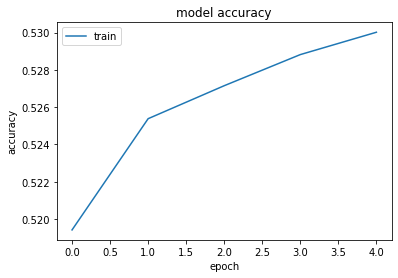

In [21]:
from matplotlib import pyplot as plt
plt.plot(fit_log.history['binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [117]:
loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print(f"Test accuracy: {np.round(loss[1],4)*100}%")

32/32 [==============================] - 0s 1ms/step - loss: nan - binary_accuracy: 0.5090
Test accuracy: 50.9%


c:\Users\nick_\.virtualenvs\dotaprediction-eZ2WDOkz\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'DotaV1' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


In [141]:
loader_single = BatchLoader(data_va, batch_size=128)
loss = model.evaluate(loader_single.load(), steps=loader_single.steps_per_epoch)
print(f"Validation accuracy: {np.round(loss[1],4)*100}%")

50/50 [==============================] - 0s 1ms/step - loss: nan - binary_accuracy: 0.5800
Test accuracy: 57.99999999999999%


c:\Users\nick_\.virtualenvs\dotaprediction-eZ2WDOkz\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'DotaV1' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
